# Linear Regression and Stochastic Gradient Descent

In [1]:
#%pip install palmerpenguins

import sys
from pathlib import Path

root = Path().resolve()

while not (root / "src" / "rice_ml").exists() and root != root.parent:
    root = root.parent

sys.path.append(str(root / "src"))

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.linear_regression import SingleNeuron
from rice_ml.supervised_learning.preprocess import train_test_split,standardize_fit, standardize_transform

sns.set_theme()

### Loading and preparing the dataset

Linear regression is a foundational algorithm in machine learning that models the relationship between input features and a continuous target variable by fitting a straight line to the data. It learns coefficients that minimize the mean squared error between predicted and actual values, providing interpretable insights into feature influence. Unlike the perceptron which classifies data into categories, linear regression predicts numeric outcomes.

We will again use the Palmer Penguins dataset is a great fit because of its inclusion of continuous numeric characteristics that have real world biological implications.

In [2]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Now we have an understanding of the Penguins dataset. Each row is an observation of a penguin, as long as some characteristics of that penguin: this includes information about its species, sex, bill legnth, flipper length, etc. Note that continuous numeric characteristics such as bill length and body mass will be of importance for our application in linear regression.

Linear regression find the function that best maps a linear relationship between two variables. Thus, it will be helpful to figure out which characteristics of penguins may have the highest linear correlations so that we can apply our model and achieve useful predictions.

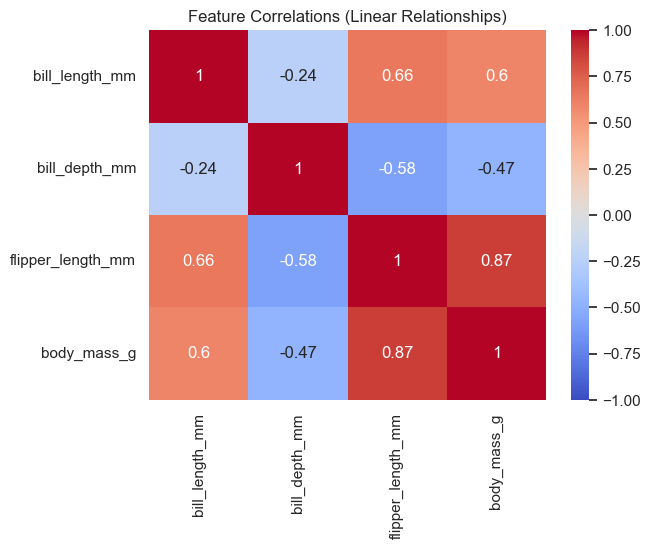

In [3]:
corr = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlations (Linear Relationships)")
plt.show()

From this heatmap, we can see that flipper length (in millimeters) and body mass (in grams) of the penguins in this dataset has a high linear correlation. Thus, we will isolate these two characteristics of penguins for use in our algorithm.

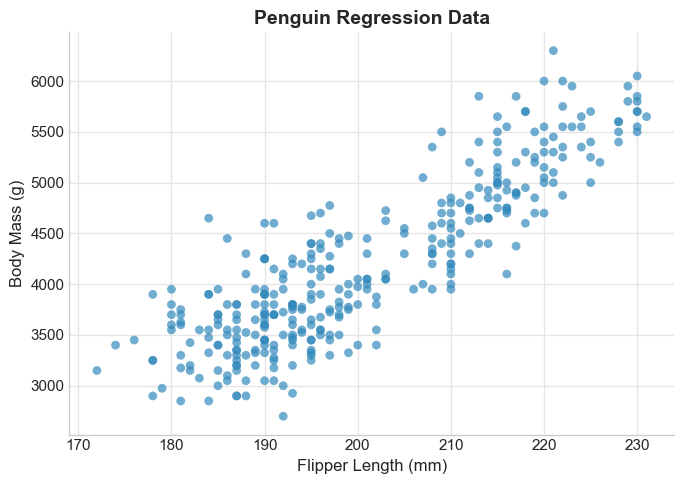

In [ ]:
# Scatterplot of flipper length vs body mass

# Use a minimal, ggplot-like style
plt.style.use("seaborn-v0_8-whitegrid")

# Create scatterplot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    penguins["flipper_length_mm"],
    penguins["body_mass_g"],
    s=40,
    color="#348ABD",
    alpha=0.7,
    edgecolor="none"
)

# Minimal theme adjustments
ax.set_title("Penguin Regression Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)", fontsize=12)
ax.set_ylabel("Body Mass (g)", fontsize=12)

# Remove top and right spines for a minimal look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Make gridlines subtle
ax.grid(True, color="0.9")

plt.tight_layout()
plt.show()


From plotting the flipper length against the body mass of our penguin observations, we can visually confirm that the two variables exhibit a highly linear relationship that can be effectively modeled through linear regression.

In [5]:
penguins_ready = penguins[["flipper_length_mm", "body_mass_g"]].dropna().reset_index(drop=True)

# Create a "vector" column where each entry is a NumPy array of features
penguins_ready["vector"] = penguins_ready[["flipper_length_mm"]].apply(lambda row: np.array(row), axis=1)

print(penguins_ready)

# Initialize model
model = SingleNeuron()
model.vector_col = "vector"
model.target_col = "body_mass_g"

# 3. Prepare the arrays for splitting
X, y = model.prepare_data(penguins_ready)

# 4. Split using your preprocess.py function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=12)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

     flipper_length_mm  body_mass_g   vector
0                181.0       3750.0  [181.0]
1                186.0       3800.0  [186.0]
2                195.0       3250.0  [195.0]
3                193.0       3450.0  [193.0]
4                190.0       3650.0  [190.0]
..                 ...          ...      ...
337              207.0       4000.0  [207.0]
338              202.0       3400.0  [202.0]
339              193.0       3775.0  [193.0]
340              210.0       4100.0  [210.0]
341              198.0       3775.0  [198.0]

[342 rows x 3 columns]
Train shapes: (274, 1) (274,)
Test shapes:  (68, 1) (68,)


We can see that in total, we have 342 observations of penguins in our dataset, 273 of which will be used for traning and 69 of which will be used for testing. In our model, flipper length is serving as the single predictor and body mass as our target characteristic.

After confirming that the x and y vectors contain the appropriate number of rows, we are ready to start training the neuron for linear regression.

In [6]:
mean_train, std_train = standardize_fit(X_train)          # fit on training data
X_train = standardize_transform(X_train, mean_train, std_train)
X_test  = standardize_transform(X_test,  mean_train, std_train)  # same scaling for test

print("\nAfter scaling:")
print("Train mean (should be ~0):", X_train.mean())
print("Train std (should be ~1):", X_train.std())


After scaling:
Train mean (should be ~0): 5.235066232904023e-16
Train std (should be ~1): 1.0


Similar to the perceptron model, we standardize our predictor variable so that weight adjustments during gradient descent are easier to manage and numerically stable.

### Training

To train our model, we are using stochastic gradient descent, which updates the model’s weights one sample at a time to minimize prediction error. For each training example, the neuron predicts a value using its current weights and bias, compares it to the true body mass, and calculates the error.

The weights are adjusted in the direction that reduces this error by a magnitude determined by the learning rate. Let us start with a learning rate (corresponding to the parameter of alpha in our "train" method) of 10 ^ -3. Let us also start by training our single neuron over 5 epochs, or full passes through the training data. With a high enough number of training epochs, the neuron's weights will accurately model the linear relationship between flipper length and body mass.

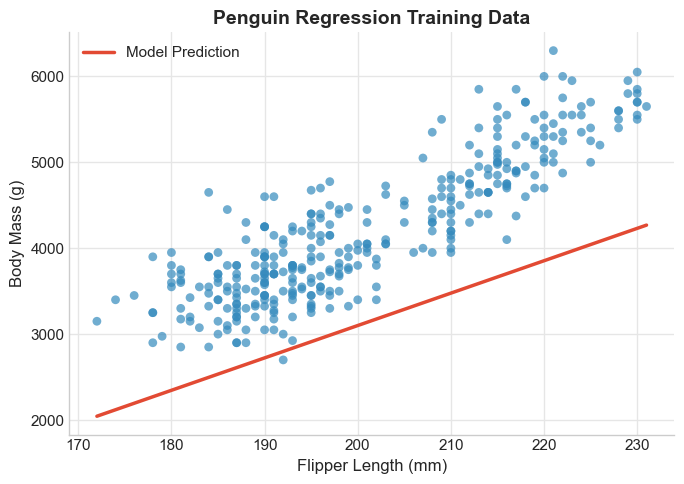

In [9]:
# Training the model over 5 epochs
model.train(X_train, y_train, alpha=1e-3, epochs=5, random_state=12)

plt.style.use("seaborn-v0_8-whitegrid")

# Create scatterplot of the original data (still in mm and g)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    penguins["flipper_length_mm"],
    penguins["body_mass_g"],
    s=40,
    color="#348ABD",
    alpha=0.7,
    edgecolor="none"
)

# Minimal theme adjustments
ax.set_title("Penguin Regression Training Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)", fontsize=12)
ax.set_ylabel("Body Mass (g)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, color="0.9")
plt.tight_layout()

# scale x_line before prediction
x_line = np.linspace(
    penguins["flipper_length_mm"].min(),
    penguins["flipper_length_mm"].max(),
    100
).reshape(-1, 1)

# scale using the same scaler fitted on X_train
x_line_scaled = standardize_transform(x_line, mean_train, std_train)

# predict on scaled data, but keep plotting x_line in original units
y_line = model.predict(x_line_scaled)

# plot the regression line
ax.plot(x_line, y_line, color="#E24A33", linewidth=2.5, label="Model Prediction")
ax.legend()
plt.show()


After 5 epochs of training, we can see that the model has captured the positive relationship between flipper length and body mass of the penguins. However, the line is not optimized to best fit the data points. As the neuron is trained over a much higher number of epochs, our predictive function would adjust to become a true line of best fit.

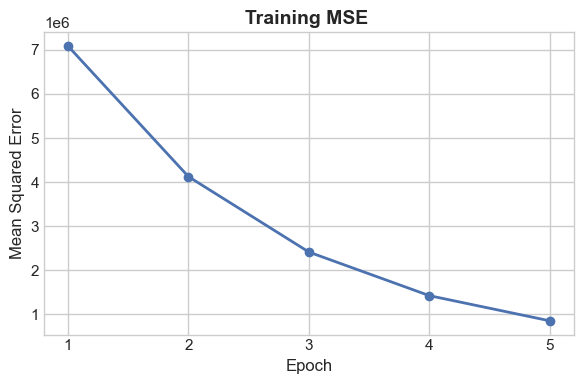

In [10]:
mse = np.asarray(model.errors_)  # length should be 5

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6,4))
plt.plot(range(1, len(mse)+1), mse, marker="o", linewidth=2)

plt.title("Training MSE ", fontsize=14, weight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)

plt.xticks(range(1, len(mse)+1))
plt.tight_layout()
plt.show()

Note that we can see our mean squared error decreasing with each training epoch. A lower mean squared error with each epoch of training indicates that our single neuron is continuing to learn and optimize its line of best fit.

Let us now train our neuron over 50 epochs to get a more optimized linear relationship between the flipper length and body mass of penguins in our dataset.

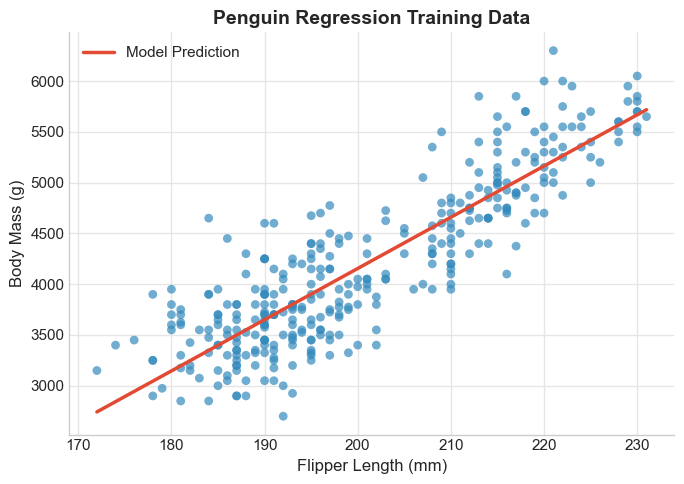

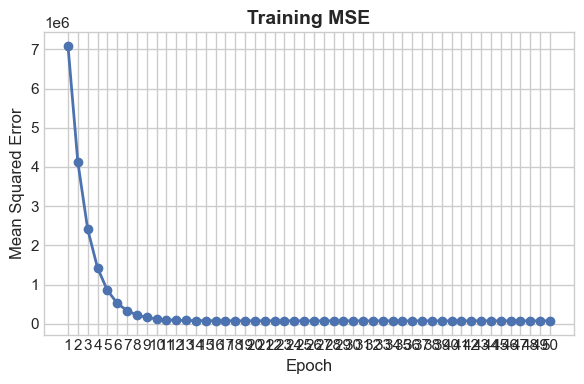

In [12]:
# Training the model over 50 epochs
model.train(X_train, y_train, alpha=1e-3, epochs=50, random_state=12)

# Use a minimal, ggplot-like style
plt.style.use("seaborn-v0_8-whitegrid")

# Create scatterplot in original units (for interpretability)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    penguins["flipper_length_mm"],
    penguins["body_mass_g"],
    s=40,
    color="#348ABD",       # soft blue
    alpha=0.7,
    edgecolor="none"
)

# Minimal theme adjustments
ax.set_title("Penguin Regression Training Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)", fontsize=12)
ax.set_ylabel("Body Mass (g)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, color="0.9")
plt.tight_layout()

# Scale x_line before predicting
x_line = np.linspace(
    penguins["flipper_length_mm"].min(),
    penguins["flipper_length_mm"].max(),
    100
).reshape(-1, 1)
x_line_scaled = standardize_transform(x_line, mean_train, std_train)
y_line = model.predict(x_line_scaled)

# Plot regression line
ax.plot(x_line, y_line, color="#E24A33", linewidth=2.5, label="Model Prediction")
ax.legend()
plt.show()

# Plot Mean Squared Error over epochs
mse = np.asarray(model.errors_)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6,4))
plt.plot(range(1, len(mse)+1), mse, marker="o", linewidth=2)

plt.title("Training MSE", fontsize=14, weight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)

plt.xticks(range(1, len(mse)+1))
plt.tight_layout()

plt.show()


We can see that our line of best fit predicted by the model now visually appears to be much more optimal, after going through 50 epochs of training. However, from our plot of the training mean squared error that our mean squared error plateaus off after around 10 epochs, implying that we may have been able to achieve similar results with 10 or 15 epochs of training rather than 50.

We are now ready to test our optimized single neuron on the untrained partition of our dataset.

### Testing / Prediction

Test R² : 0.705


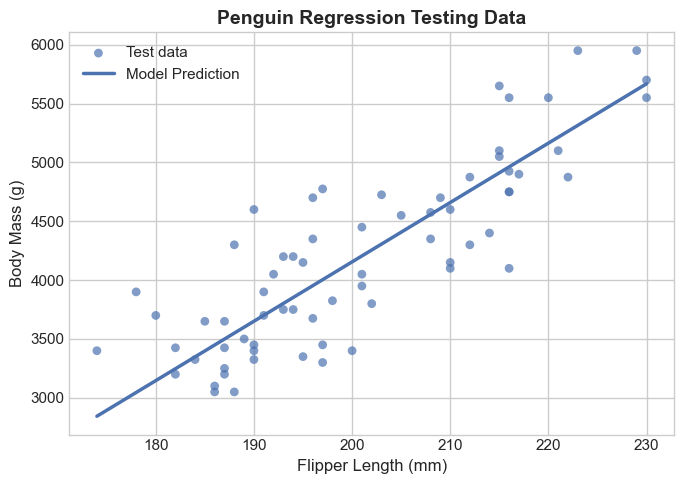

In [14]:
from sklearn.metrics import r2_score

# Predict on the (already scaled) test features
y_pred_test = model.predict(X_test)   # X_test is already standardized

# Evaluate
r2 = r2_score(y_test, y_pred_test)
print(f"Test R² : {r2:.3f}")

# ----- Plot test scatter + model line (axes in original units) -----

# Recover flipper length in original mm units from standardized X_test
# (X_test was obtained via: X_test = (X_test_raw - mean_train) / std_train)
X_test_raw = X_test * std_train + mean_train   # shape (n_test, 1)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(7, 5))

# Scatter in original units
ax.scatter(
    X_test_raw[:, 0],   # flipper length in mm
    y_test,             # body mass in grams
    s=40,
    alpha=0.7,
    edgecolor="none",
    label="Test data",
)

# Model line: build x in mm, scale it, predict, plot against mm
x_line = np.linspace(X_test_raw.min(), X_test_raw.max(), 200).reshape(-1, 1)
x_line_scaled = standardize_transform(x_line, mean_train, std_train)
y_line = model.predict(x_line_scaled)

ax.plot(x_line, y_line, linewidth=2.5, label="Model Prediction")

ax.set_title("Penguin Regression Testing Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")
ax.legend()
plt.tight_layout()
plt.show()


Overlaying our testing data with the line of best fit generated by our single neuron from the testing data, we can visually confirm that it seems to effectively explain the linear relationship between flipper length and body mass of penguins. Our R^2 value of 0.791 indicates that ~79% of the variation in body mass can be explained by differences in the flipper lengths of the penguins.

In [16]:
# Predict on test set (X_test is already standardized)
y_pred_test = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(np.mean((y_pred_test - y_test) ** 2))
print(f"Test RMSE: {rmse:.2f} g")

# Recover flipper length in original mm units from standardized X_test
# (assuming a single feature: flipper_length_mm)
X_test_raw = X_test * std_train + mean_train      # shape (n_test, 1)
flipper_mm = X_test_raw[:, 0]

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Flipper Length (mm)": flipper_mm,
    "Actual Body Mass (g)": y_test,
    "Predicted Body Mass (g)": y_pred_test,
})

# Compute error per row
comparison_df["Error (g)"] = (
    comparison_df["Predicted Body Mass (g)"] - comparison_df["Actual Body Mass (g)"]
).round(1)

# Show 3 random samples for display
sample = comparison_df.sample(3, random_state=12).reset_index(drop=True)

# Format neatly
display(sample.style.format({
    "Flipper Length (mm)": "{:.1f}",
    "Actual Body Mass (g)": "{:.1f}",
    "Predicted Body Mass (g)": "{:.1f}",
    "Error (g)": "{:+.1f}",
}))

Test RMSE: 414.65 g


,Flipper Length (mm),Actual Body Mass (g),Predicted Body Mass (g),Error (g)
0,201.0,3950.0,4205.3,+255.3
1,187.0,3250.0,3499.2,+249.2
2,196.0,4350.0,3953.1,-396.9


We can now randomly pick three flipper length data points from our testing data to compare their actual body mass against what was predicted by our linear regression model.

The model achieved a test root mean squared error of approximately 349 grams, meaning its predictions are typically within about 350 grams of the actual body mass. The three data points displayed in the table all have an error of less than plus/minus 350 grams. Given that typical penguins in our data set weigh betweeen 3,000 to 6,000 grams, this error indicates that our neuron was able to effectively capture the linear relationship between flipper length and body mass even for the unseen data in our testing set.
